# Dielectric to plasmonic waveguide coupler design via Bayesian optimization

This notebook explores the design and simulation of a dielectric-to-plasmonic waveguide coupler using Tidy3D. Such couplers enable efficient transfer of optical signals from conventional silicon photonic waveguides to plasmonic waveguides, which support highly confined modes beyond the diffraction limit.

The coupler features a silicon strip waveguide that gradually tapers into a metallic slot waveguide. We utilize Bayesian optimization to systematically refine the design for maximum coupling efficiency.

<img src="./img/silicon_to_plasmonic.png" alt="Schematic of the 2x2 MMI Power Splitter"  width="500"/>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Base Simulation Setup

Define central wavelength/frequency, a wavelength range, and its mapped frequency grid.


In [2]:
# define frequency and wavelength range
lda0 = 1.50
freq0 = td.C_0 / lda0
ldas = np.linspace(1.45, 1.55, 21)
freqs = td.C_0 / ldas
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))

Load silicon, silica, and gold mediums from the built-in [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html) for the coupler stack.


In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]
au = td.material_library["Au"]["Olmon2012crystal"]

Set static geometric parameters such as the plasmonic slot length, silicon/gold layer thickness, slot width, and so on.


In [4]:
l_slot = 1.5  # plasmonic waveguide length
h = 0.25  # both silicon and gold layer thicknesses are 250 nm
w_slot = 0.2  # metal slot width
w_si = 0.45  # silicon waveguide width
inf_eff = 1e2  # effective infinity
buffer = 0.6 * lda0  # buffer spacing to pad the simulation domain

To streamline the design optimization process, we define a function `make_sim()` which accepts tunable design parameters including the taper angle, taper tip width, and gap size, and constructs a corresponding Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation) object.


In [5]:
# define the oxide layer
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# add a mode source for excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.47)
mode_source = td.ModeSource(
    center=(-0.9 * buffer, 0, h / 2),
    size=(0, 4 * w_si, 6 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=mode_spec,
    mode_index=0,
    direction="+",
    num_freqs=1,
)

# add a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, h / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# extrusion arguments for polyslab
polyslab_args = dict(axis=2, slab_bounds=(0, h))


# function to create a simulation given the design parameters
def make_sim(theta, d_tip, l_gap):
    # calculate the taper length
    l_taper = (w_si - d_tip) / (2 * np.tan(theta))

    # define the input waveguide structure
    vertices = [
        (-inf_eff, -w_si / 2),
        (0, -w_si / 2),
        (l_taper, -d_tip / 2),
        (l_taper, d_tip / 2),
        (0, w_si / 2),
        (-inf_eff, w_si / 2),
    ]
    wg_in = td.Structure(geometry=td.PolySlab(vertices=vertices, **polyslab_args), medium=si)

    # define the output waveguide structure
    vertices = [
        (l_taper + 2 * l_gap + l_slot, d_tip / 2),
        (2 * l_taper + 2 * l_gap + l_slot, w_si / 2),
        (inf_eff, w_si / 2),
        (inf_eff, -w_si / 2),
        (2 * l_taper + 2 * l_gap + l_slot, -w_si / 2),
        (l_taper + 2 * l_gap + l_slot, -d_tip / 2),
    ]
    wg_out = td.Structure(geometry=td.PolySlab(vertices=vertices, **polyslab_args), medium=si)

    # define the top plasmonic waveguide
    vertices = [
        (l_taper + l_gap, w_slot / 2),
        (l_taper + l_gap + l_slot, w_slot / 2),
        (inf_eff, np.tan(theta) * inf_eff),
        (-inf_eff, np.tan(theta) * inf_eff),
    ]
    gold_top = td.Structure(geometry=td.PolySlab(vertices=vertices, **polyslab_args), medium=au)

    # define the bottom plasmonic waveguide
    vertices = [
        (l_taper + l_gap, -w_slot / 2),
        (l_taper + l_gap + l_slot, -w_slot / 2),
        (inf_eff, -np.tan(theta) * inf_eff),
        (-inf_eff, -np.tan(theta) * inf_eff),
    ]
    gold_bottom = td.Structure(geometry=td.PolySlab(vertices=vertices, **polyslab_args), medium=au)

    # add a mode monitor to measure transmission
    mode_monitor = td.ModeMonitor(
        center=(2 * l_taper + l_slot + 2 * l_gap + 0.9 * buffer, 0, h / 2),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode",
    )

    # define simulation
    sim = td.Simulation(
        center=(l_taper + l_gap + l_slot / 2, 0, h / 2),
        size=(2 * l_taper + 2 * l_gap + l_slot + 2 * buffer, w_si + 2 * buffer, h + 2 * buffer),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.absorber(num_layers=80),
            y=td.Boundary.absorber(),
            z=td.Boundary.pml(),
        ),
        run_time=5e-13,
        structures=[box, wg_in, wg_out, gold_top, gold_bottom],
        sources=[mode_source],
        monitors=[mode_monitor, field_monitor],
        symmetry=(0, -1, 0),
    )

    return sim

Build a first design instance and render a top view at `z = h/2` to confirm geometry, source, and monitor locations.


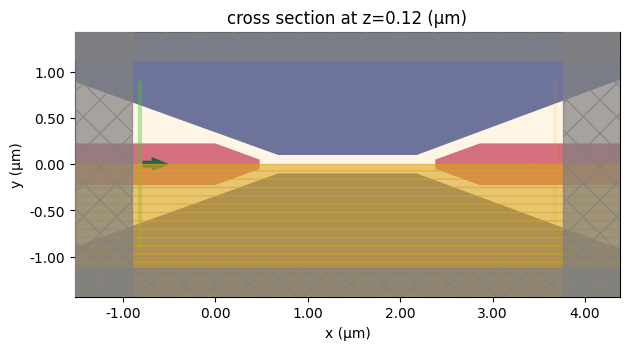

In [6]:
sim = make_sim(theta=np.deg2rad(20), d_tip=0.1, l_gap=0.2)
sim.plot(z=h / 2, monitor_alpha=0.1)
plt.show()

Submit the initial simulation to the cloud to generate fields and monitor data for the baseline geometry.


In [7]:
sim_data = web.run(sim, "test run")

21:11:22 Eastern Daylight Time Created task 'test run' with task_id             
                               'fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=933873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=858921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1\taskId]8;;\
                               ]8;id=933873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1\=]8;;\]8;id=438469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1\fdve]8;;\]8;id=933873;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1\-ef0ea98f-26b9-4a2c-8b50-827a0a39c3e1']8;;\.

                               Task folder: ]8;id=713502;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

21:11:24 Eastern Daylight Time Maximum FlexCredit cost: 0.318. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

21:11:25 Eastern Daylight Time status = success

Output()

21:11:26 Eastern Daylight Time loading simulation from simulation_data.hdf5

Plot the real part of Hz on the $xy$ plane to inspect coupling in the initial (non‑optimized) geometry.


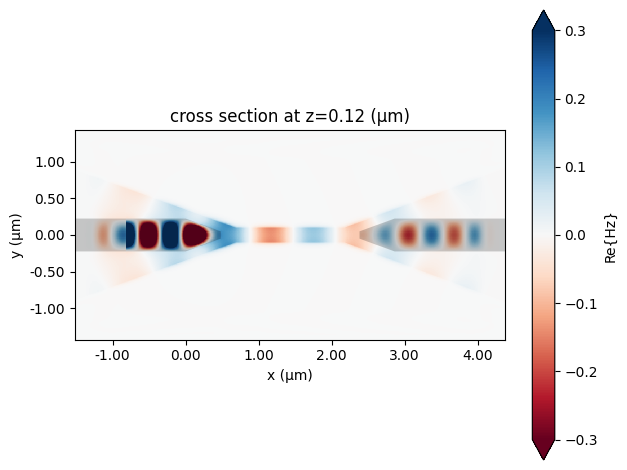

In [8]:
sim_data.plot_field("field", "Hz", "real", vmax=0.3)
plt.show()

## Bayesian Optimization

Define an objective function that computes the average broadband transmission
power in the fundamental mode based on simulation results. This serves as
the figure of merit to be maximized during optimization.

For reference, the initial (unoptimized) device achieves a mean broadband transmission of 12.8%.


In [9]:
def cal_transmission(sim_data):
    amp = sim_data["mode"].amps.sel(mode_index=0, direction="+").values
    T = np.abs(amp) ** 2
    return np.mean(T)


print(f"Transmission = {1e2 * cal_transmission(sim_data):.2f}%")

Transmission = 12.83%


Configure `tidy3d.plugins.design` to maximize transmission by sweeping `theta`, `d_tip`, and `l_gap` within bounds using a UCB (upper confidence bound) acquisition function.


In [10]:
import tidy3d.plugins.design as tdd

# define optimization method
method = tdd.MethodBayOpt(
    initial_iter=10,
    n_iter=15,
    acq_func="ucb",
    kappa=0.3,
    seed=1,
)

# define optimization parameters
parameters = [
    tdd.ParameterFloat(name="theta", span=(np.deg2rad(5), np.deg2rad(20))),
    tdd.ParameterFloat(name="d_tip", span=(0.05, 0.2)),
    tdd.ParameterFloat(name="l_gap", span=(0.1, 0.3)),
]

# define a design space
design_space = tdd.DesignSpace(
    method=method, parameters=parameters, task_name="bay_opt", path_dir="./data"
)

# run the design optimization
results = design_space.run(make_sim, cal_transmission, verbose=True)

21:11:29 Eastern Daylight Time Running 10 Simulations

21:11:58 Eastern Daylight Time Best Fit from Initial Solutions: 0.322           
                               

                               Running 1 Simulations

21:12:49 Eastern Daylight Time Latest Best Fit on Iter 0: 0.355                 
                               

                               Running 1 Simulations

21:14:06 Eastern Daylight Time Latest Best Fit on Iter 1: 0.361                 
                               

21:14:07 Eastern Daylight Time Running 1 Simulations

21:15:23 Eastern Daylight Time Running 1 Simulations

21:16:12 Eastern Daylight Time Latest Best Fit on Iter 3: 0.373                 
                               

                               Running 1 Simulations

21:17:31 Eastern Daylight Time Latest Best Fit on Iter 4: 0.374                 
                               

                               Running 1 Simulations

21:18:19 Eastern Daylight Time Latest Best Fit on Iter 5: 0.379                 
                               

21:18:20 Eastern Daylight Time Running 1 Simulations

21:19:04 Eastern Daylight Time Latest Best Fit on Iter 6: 0.381                 
                               

                               Running 1 Simulations

21:20:25 Eastern Daylight Time Latest Best Fit on Iter 7: 0.387                 
                               

21:20:26 Eastern Daylight Time Running 1 Simulations

21:21:14 Eastern Daylight Time Latest Best Fit on Iter 8: 0.389                 
                               

21:21:15 Eastern Daylight Time Running 1 Simulations

21:22:36 Eastern Daylight Time Latest Best Fit on Iter 9: 0.395                 
                               

                               Running 1 Simulations

21:23:57 Eastern Daylight Time Running 1 Simulations

21:25:17 Eastern Daylight Time Latest Best Fit on Iter 11: 0.4                  
                               

21:25:18 Eastern Daylight Time Running 1 Simulations

21:26:38 Eastern Daylight Time Running 1 Simulations

21:28:00 Eastern Daylight Time Latest Best Fit on Iter 13: 0.401                
                               

                               Running 1 Simulations

21:29:22 Eastern Daylight Time Latest Best Fit on Iter 14: 0.401                
                               

                               Best Result: 0.401350274778198                   
                               Best Parameters: d_tip: 0.13292462551997172      
                               l_gap: 0.1 theta: 0.08726646259971647            
                               

Rebuild the simulation with the best parameters from optimization.


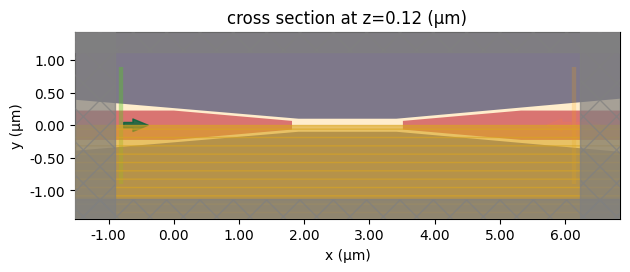

In [11]:
sim_opt = make_sim(**results.optimizer.max["params"])
sim_opt.plot(z=h / 2, monitor_alpha=0.2)
plt.show()

Run the optimized simulation (cached) again and plot the real part of `Hz` on the $xy$ plane to confirm efficient coupling into the slot plasmonic mode.


21:29:23 Eastern Daylight Time Created task 'optimal design' with task_id       
                               'fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=707335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=182780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a\taskId]8;;\
                               ]8;id=707335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a\=]8;;\]8;id=169619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a\fdve]8;;\]8;id=707335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-33c63420-9e17-4c9c-b46a-929b1a526b2a\-33c63420-9e17-4c9c-b46a-929b1a526b2a']8;;\.

                               Task folder: ]8;id=684768;https://tidy3d.simulation.cloud/folders/639eb096-a602-4b56-a502-cac1f18f9557\'default']8;;\.

Output()

21:29:24 Eastern Daylight Time Maximum FlexCredit cost: 0.448. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

21:29:25 Eastern Daylight Time status = success

Output()

21:29:26 Eastern Daylight Time loading simulation from simulation_data.hdf5

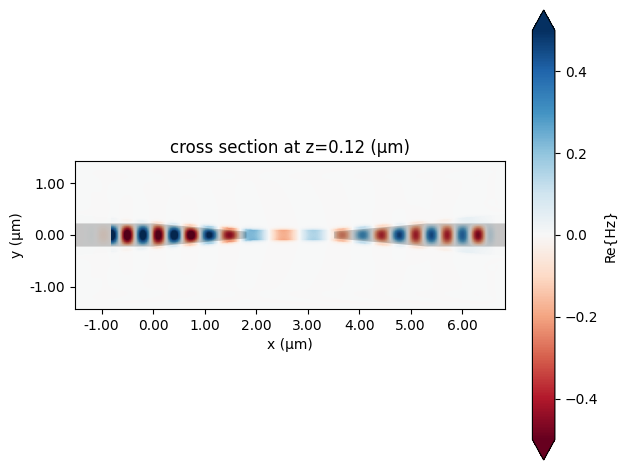

In [12]:
sim_data_opt = web.run(sim_opt, "optimal design")
sim_data_opt.plot_field("field", "Hz", "real", vmax=0.5)
plt.show()

Finally, compute and plot power transmission from the mode monitor across the wavelength range.


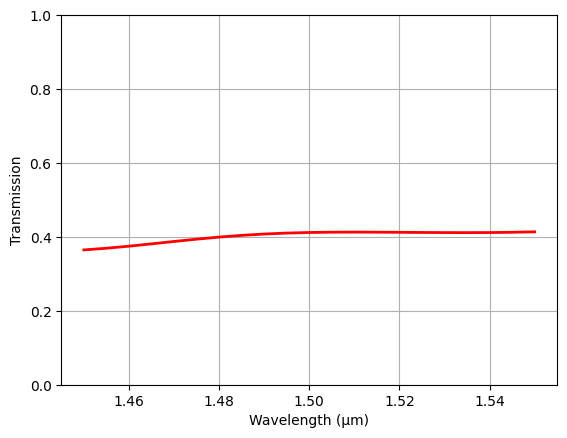

In [13]:
amp = sim_data_opt["mode"].amps.sel(mode_index=0, direction="+")
T = np.abs(amp) ** 2
plt.plot(ldas, T, c="red", linewidth=2)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transmission")
plt.ylim(0, 1)
plt.grid()
plt.show()